In [87]:
# so modules are automatically reloaded when they are changed
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from mynotebooks.results_utils import *
import torch
import pickle
import seaborn as sns

from sklearn.metrics import roc_auc_score, balanced_accuracy_score


import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance,wasserstein_distance_nd
import ot
from itertools import combinations


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Baseline analysis pipeline

In [ ]:
ROOT = ''
experiment_folder = ''

random_seed_folders = ['42','43','44']
data_folder = ''
experiment = ''

class_name = 'adj-bp'

path_to_train_splits = os.path.join(ROOT,'data/ukbb-ret',data_folder,'splits','train-'+class_name+'.csv')
path_to_val_splits = os.path.join(ROOT,'data/ukbb-ret',data_folder,'splits','val-'+class_name+'.csv')
path_to_test_splits = os.path.join(ROOT,'data/ukbb-ret',data_folder,'splits','test-'+class_name+'.csv')

pred_file = 'pretrained_pred.csv'

subgroups = ['Age_multi','Sex','bmi_cat','alcohol','assessment_centre','deprivation_index','ethnicity','gen_ethnicity']

all_models_dict = {}
train_val_dict = {}

for i,random_seed_folder in enumerate(random_seed_folders):
    results_folder = os.path.join(ROOT,experiment_folder,experiment,random_seed_folder)

    print('getting train val preds')

    train_preds,val_preds = get_val_train_preds(results_folder,path_to_train_splits,path_to_val_splits)
    
    print('getting test preds')

    test_preds = preprocess_ukbb_data(os.path.join(results_folder,pred_file),path_to_test_splits)

    print('processing')

    # test results
    test_results_df = make_test_results_df([test_preds],subgroups)
    test_results_df.set_index('Subgroup',inplace=True)

    overall_test_results_df = pd.DataFrame(test_results_df.iloc[0][['Test Acc','Test AUC','Test Precision','Test Recall']])
    overall_test_results_df.rename(columns={'Age_multi':'Overall'},inplace=True)

    disparities_test_results_df = pd.DataFrame(test_results_df[[x for x in test_results_df.columns if 'Gap' in x or 'Min' in x]])

    # train/val results
    train_val_results_df = make_results_df(train_preds,val_preds,subgroups)
    train_val_results_df.set_index('Subgroup',inplace=True)

    train_val_results_df['Train Val Acc Gap'] = train_val_results_df['Train Acc Gap'] - train_val_results_df['Val Acc Gap']
    train_val_results_df['Train Val AUC Gap'] = train_val_results_df['Train AUC Gap'] - train_val_results_df['Val AUC Gap']
    train_val_results_df['Train Val Precision Gap'] = train_val_results_df['Train Precision Gap'] - train_val_results_df['Val Precision Gap']
    train_val_results_df['Train Val Recall Gap'] = train_val_results_df['Train Recall Gap'] - train_val_results_df['Val Recall Gap']

    all_models_dict = {**all_models_dict, **{random_seed_folder: {'test_preds': test_preds,'test_results': test_results_df, 'overall_test_results': overall_test_results_df, 'disparities_test_results': disparities_test_results_df,'train_val': train_val_results_df}}}
    train_val_dict = {**train_val_dict, **{random_seed_folder: {'train_preds': train_preds,'val_preds': val_preds}}}

getting train val preds


/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))


getting test preds
processing
getting train val preds


/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))


getting test preds
processing
getting train val preds


/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:50: RuntimeWarning: invalid value encountered in true_divide
  f1 = np.multiply(2, np.divide(np.multiply(p, r), np.add(r, p)))


getting test preds
processing


## Overall performance

In [89]:
all_overall_test_results = pd.concat([all_models_dict[x]['overall_test_results'].T for x in all_models_dict.keys()])
all_overall_test_results = all_overall_test_results.apply(pd.to_numeric)
mean_std = all_overall_test_results.describe().loc[['mean', 'std']]
mean_std


,Test Acc,Test AUC,Test Precision,Test Recall
mean,0.730539,0.705415,0.813630,0.828747
std,0.013596,0.004023,0.006887,0.033490


## Test set disparities

In [90]:
all_disparities_test_results = pd.concat([all_models_dict[x]['disparities_test_results'] for x in all_models_dict.keys()])

df_mean = all_disparities_test_results.groupby(level=0).mean().round(3)
df_std = all_disparities_test_results.groupby(level=0).std().round(3)

all_results_df = df_mean.astype(str)
all_results_df = all_results_df + ' (' + df_std.astype(str) + ')'
all_results_df.rename(columns={'Test Acc Gap':'Accuracy Gap','Test Min Acc':'Min Accuracy','Test Min AUC':'Min AUC','Test AUC Gap':'AUC Gap','Test Min Precision':'Min Precision','Test Precision Gap':'Precision Gap','Test Min Recall':'Min Recall','Test Recall Gap':'Recall Gap','Test TNR Gap':'TNR Gap','Test Min TNR':'Min TNR'},inplace=True)
all_results_df

,Accuracy Gap,Min Accuracy,AUC Gap,Min AUC,Precision Gap,Min Precision,Recall Gap,Min Recall,TNR Gap,Min TNR
Subgroup,,,,,,,,,,
Age_multi,0.187 (0.017),0.639 (0.017),0.15 (0.04),0.55 (0.045),0.129 (0.005),0.724 (0.008),0.328 (0.045),0.643 (0.055),0.598 (0.033),0.036 (0.031)
Sex,0.062 (0.009),0.701 (0.009),0.033 (0.002),0.676 (0.004),0.067 (0.005),0.78 (0.009),0.068 (0.009),0.794 (0.032),0.135 (0.024),0.356 (0.052)
alcohol,0.102 (0.005),0.673 (0.017),0.067 (0.009),0.67 (0.01),0.055 (0.009),0.79 (0.012),0.124 (0.015),0.756 (0.043),0.149 (0.02),0.364 (0.038)
assessment_centre,0.061 (0.012),0.706 (0.013),0.104 (0.004),0.642 (0.005),0.097 (0.012),0.776 (0.01),0.149 (0.013),0.775 (0.029),0.357 (0.031),0.219 (0.06)
bmi_cat,0.141 (0.023),0.65 (0.005),0.033 (0.003),0.677 (0.004),0.239 (0.007),0.672 (0.011),0.065 (0.003),0.782 (0.03),0.082 (0.008),0.384 (0.05)
deprivation_index,0.019 (0.006),0.722 (0.013),0.015 (0.004),0.698 (0.002),0.024 (0.011),0.802 (0.012),0.019 (0.01),0.821 (0.037),0.045 (0.02),0.422 (0.051)
ethnicity,0.041 (0.011),0.703 (0.034),0.029 (0.019),0.693 (0.004),0.041 (0.01),0.813 (0.007),0.106 (0.019),0.73 (0.048),0.217 (0.02),0.401 (0.002)
gen_ethnicity,0.019 (0.011),0.715 (0.018),0.006 (0.004),0.703 (0.003),0.005 (0.004),0.809 (0.008),0.039 (0.012),0.797 (0.036),0.068 (0.008),0.429 (0.047)


In [91]:
df_std = df_std.rename(columns={'Test Acc Gap':'Accuracy Gap','Test AUC Gap':'AUC Gap','Test Precision Gap':'Precision Gap','Test Recall Gap':'Recall Gap'})
df_std.index = ['Age','Sex','Alcohol','Centre',  'BMI','Deprivation','Ethnicity', 'Gen_ethnicity']

subset_test_results_df = df_mean[['Test Acc Gap','Test AUC Gap','Test Precision Gap','Test Recall Gap']]
subset_test_results_df = subset_test_results_df.rename(columns={'Test Acc Gap':'Accuracy Gap','Test AUC Gap':'AUC Gap','Test Precision Gap':'Precision Gap','Test Recall Gap':'Recall Gap'})
subset_test_results_df.index = ['Age','Sex','Alcohol','Centre',  'BMI','Deprivation','Ethnicity', 'Gen_ethnicity']
gap_test_results_df = subset_test_results_df.sort_values('AUC Gap',ascending=False)

In [92]:
subset_test_results_df = df_mean[['Test Min Acc','Test Min AUC','Test Min Precision','Test Min Recall']]
subset_test_results_df.index = ['Age','Sex','Alcohol','Centre',  'BMI','Deprivation','Ethnicity', 'Gen_ethnicity']

subset_test_results_df = subset_test_results_df.sort_values('Test Min AUC',ascending=True)

subset_test_results_df = subset_test_results_df.rename(columns={'Test Min Acc':'Min Accuracy','Test Min AUC': 'Min AUC', 'Test Min Precision': 'Min Precision', 'Test Min Recall': 'Min Recall'})
df_std = df_std.rename(columns={'Test Min Acc':'Min Accuracy','Test Min AUC': 'Min AUC', 'Test Min Precision': 'Min Precision', 'Test Min Recall': 'Min Recall'})
df_std.index = ['Age','Sex','Alcohol','Centre',  'BMI','Deprivation','Ethnicity', 'Gen_ethnicity']

min_test_results_df = subset_test_results_df
std_min_test_results_df = df_std[['Min Accuracy','Min AUC','Min Precision','Min Recall']]

In [97]:
min_max_test_results_df = pd.DataFrame()
min_max_test_results_df['Min AUC']= min_test_results_df['Min AUC']
min_max_test_results_df['Max AUC'] = min_test_results_df['Min AUC']+gap_test_results_df['AUC Gap']
min_max_test_results_df['Mean AUC'] = mean_std['Test AUC'][0]
min_max_test_results_df['STD AUC'] = std_min_test_results_df['Min AUC']
min_max_test_results_df['Group'] = min_max_test_results_df.index
min_max_test_results_df

,Min AUC,Max AUC,Mean AUC,STD AUC,Group
Age,0.550,0.700,0.705415,0.045,Age
Centre,0.642,0.746,0.705415,0.005,Centre
Alcohol,0.670,0.737,0.705415,0.010,Alcohol
Sex,0.676,0.709,0.705415,0.004,Sex
BMI,0.677,0.710,0.705415,0.004,BMI
Ethnicity,0.693,0.722,0.705415,0.004,Ethnicity
Deprivation,0.698,0.713,0.705415,0.002,Deprivation
Gen_ethnicity,0.703,0.709,0.705415,0.003,Gen_ethnicity


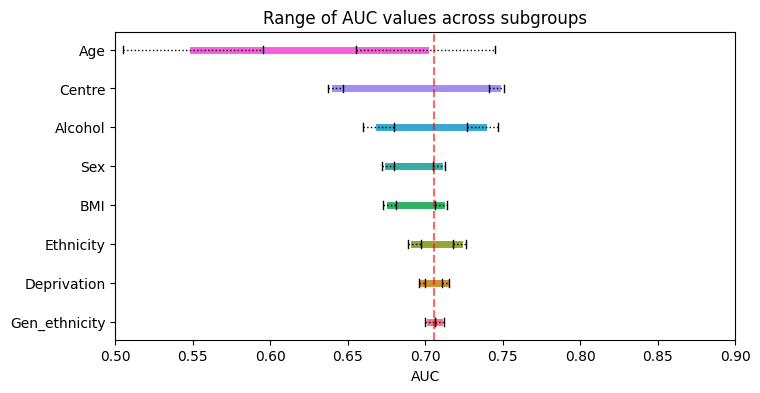

In [98]:
df = min_max_test_results_df
df = df.iloc[::-1].reset_index(drop=True)
palette = sns.color_palette("husl", len(df))

plt.figure(figsize=(8, 4))
for index, row in df.iterrows():
    plt.plot([row['Min AUC'], row['Max AUC']], [row['Group'], row['Group']], color=palette[index], linewidth=5)

    # Add SD lines (dotted)
    plt.plot([row['Min AUC'] - row['STD AUC'], row['Min AUC'] + row['STD AUC']], 
             [row['Group'], row['Group']], color='black', linestyle=':', linewidth=1)
    plt.plot([row['Max AUC'] - row['STD AUC'], row['Max AUC'] + row['STD AUC']], 
             [row['Group'], row['Group']], color='black', linestyle=':', linewidth=1)

    # Add ticks at the ends of the SD lines
    plt.plot([row['Min AUC'] - row['STD AUC'], row['Min AUC'] - row['STD AUC']], 
             [index - 0.1, index + 0.1], color='black', linewidth=1)
    plt.plot([row['Min AUC'] + row['STD AUC'], row['Min AUC'] + row['STD AUC']], 
             [index - 0.1, index + 0.1], color='black', linewidth=1)
    plt.plot([row['Max AUC'] - row['STD AUC'], row['Max AUC'] - row['STD AUC']], 
             [index - 0.1, index + 0.1], color='black', linewidth=1)
    plt.plot([row['Max AUC'] + row['STD AUC'], row['Max AUC'] + row['STD AUC']], 
             [index - 0.1, index + 0.1], color='black', linewidth=1)

plt.yticks(range(len(df['Group'])), df['Group'])
plt.xlim([0.5, 0.9])
# plot vertical dotted red line at x= 0.705
plt.axvline(x=0.705415, color='red', linestyle='--',alpha=0.6)
plt.xlabel('AUC')
plt.title('Range of AUC values across subgroups')
plt.show()

### Condition on certain variables when looking at test set disparities


In [99]:
groups = ['Sex','assessment_centre'] # can do this for lots of different subgroups (either 1 or 2 at a time)

conditional_dfs = []
for test_preds in [all_models_dict[x]['test_preds'] for x in all_models_dict.keys()]:
    conditional_df = conditional_metrics(test_preds,groups)
    conditional_dfs.append(conditional_df)

df_mean = pd.concat(conditional_dfs).groupby(level=[0,1]).mean()
df_std = pd.concat(conditional_dfs).groupby(level=[0,1]).std()


df_mean.drop(columns=['Accuracy','Precision','Recall','TNR'],inplace=True)
df_mean.round(3)

AUC
Sex assessment_centre       
F   11014.0            0.704
    11016.0            0.728
    11018.0            0.731
    11020.0            0.718
    11021.0            0.747
    11024.0            0.663
M   11014.0            0.723
    11016.0            0.659
    11018.0            0.744
    11020.0            0.692
    11021.0            0.685
    11024.0            0.580

## Train/val evolution

In [100]:
with open('all_filt2_baseline_inceptionv3_train_val_dict.pkl', 'rb') as f:
    train_val_dict = pickle.load(f)

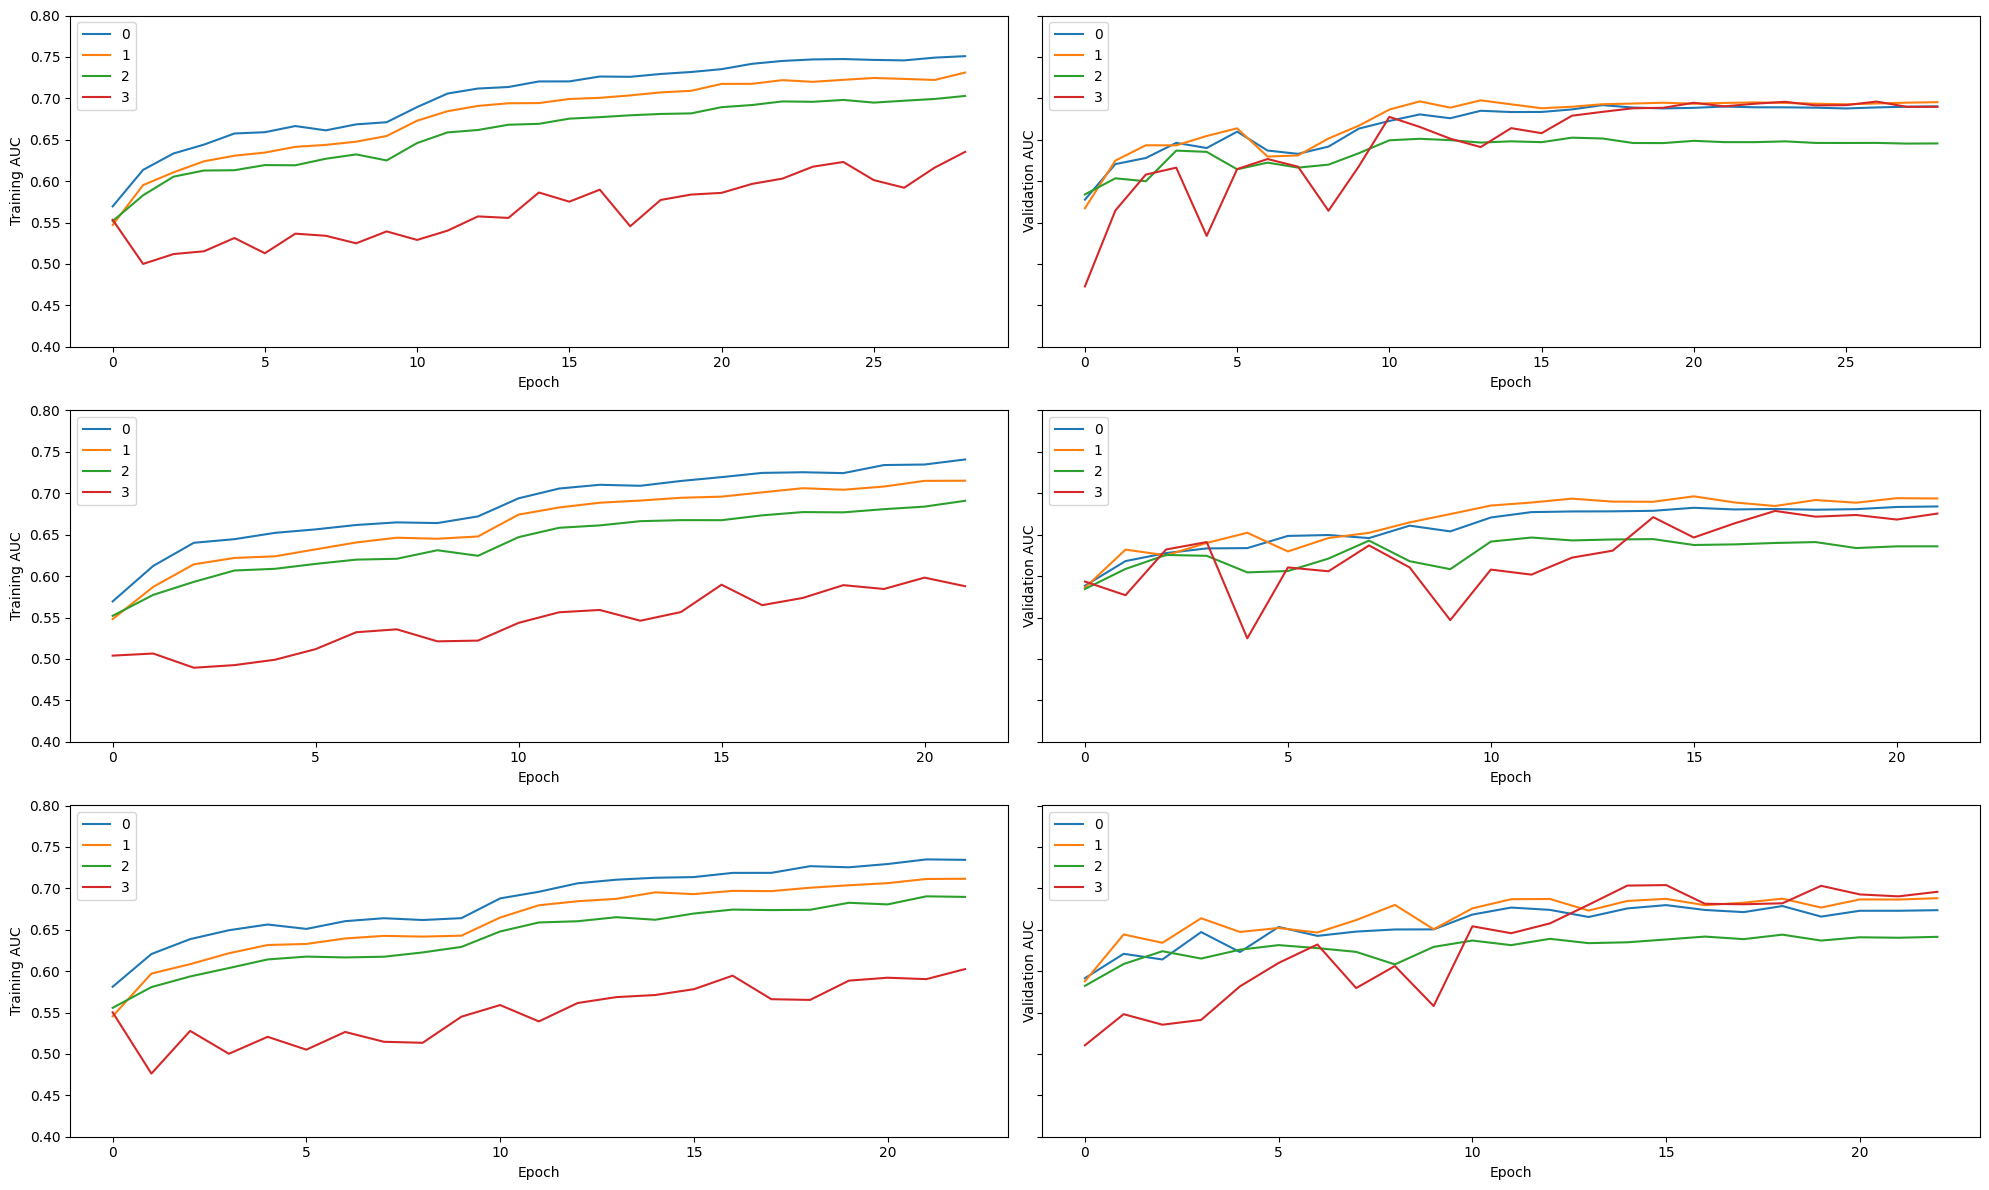

In [101]:
random_seed ='42' # choose relevant seed
subgroup = 'Age_multi' # can choose any
train_preds,val_preds = train_val_dict['44']['train_preds'],train_val_dict['44']['val_preds']

train_preds_list,val_preds_list = [train_val_dict[x]['train_preds'] for x in train_val_dict.keys()],[train_val_dict[x]['val_preds'] for x in train_val_dict.keys()]
plot_subgroup_model_stats(train_preds_list,val_preds_list, subgroup,plot_gap=False,plot_auc=True,plot_all=True)

## Image embeddings analysis

[0.65174454 0.16227518 0.06775103 0.03013833 0.01639621]
[0.52286613 0.21201469 0.06660374 0.05547487 0.0386488 ]
[0.53885007 0.18093966 0.0934502  0.06956036 0.02663985]


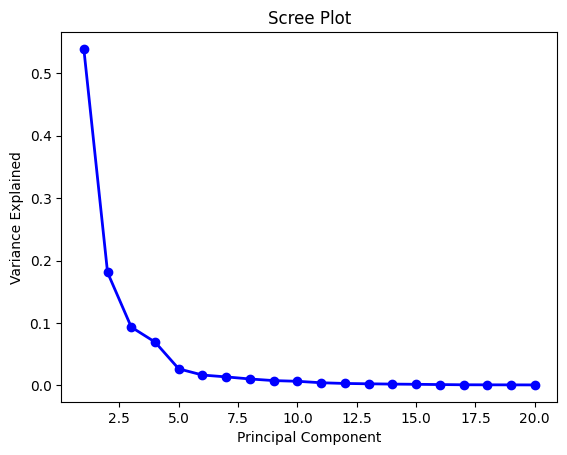

In [113]:
ROOT = ''
bsl_folder = 'baseline'
# bsl_folder = 'SWAD'
# bsl_folder = 'resamplingSWAD'
# bsl_folder = 'GroupDRO'
# bsl_folder = 'resampling'
# bsl_folder = 'LNL'

experiment_folder = ''
experiments = ['42','43','44'] #,'baseline_adj_1','baseline_adj_2']
path_to_test_splits = ''
centre_dict = {11014.0: 'a', 11016.0: 'b', 11018.0: 'c', 11020.0: 'd', 11021.0: 'e', 11024.0: 'f'}

bsl_experiment_dict = {}
for experiment in experiments:
    features_path = os.path.join(ROOT,bsl_folder,experiment_folder,experiment,'features.pt')
    index_path = os.path.join(ROOT,bsl_folder,experiment_folder,experiment,'index.pt')
    features = torch.load(features_path)
    index = torch.load(index_path)
    test_preds = preprocess_ukbb_data(os.path.join(ROOT,bsl_folder,experiment_folder,experiment,'pretrained_pred.csv'),path_to_test_splits)
    # reorder test_preds according to values in index tensor
    test_preds = test_preds.iloc[index.numpy()]
    test_preds['assessment_centre'] = test_preds['assessment_centre'].map(centre_dict)
    results_df = conduct_pca(features,test_preds)
    bsl_experiment_dict[experiment] = results_df

#check scree plot
X = features.numpy()
std_scaler = StandardScaler()
scaled_X = std_scaler.fit_transform(X)
pca = PCA(n_components=20)
pconp = pca.fit_transform(scaled_X)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

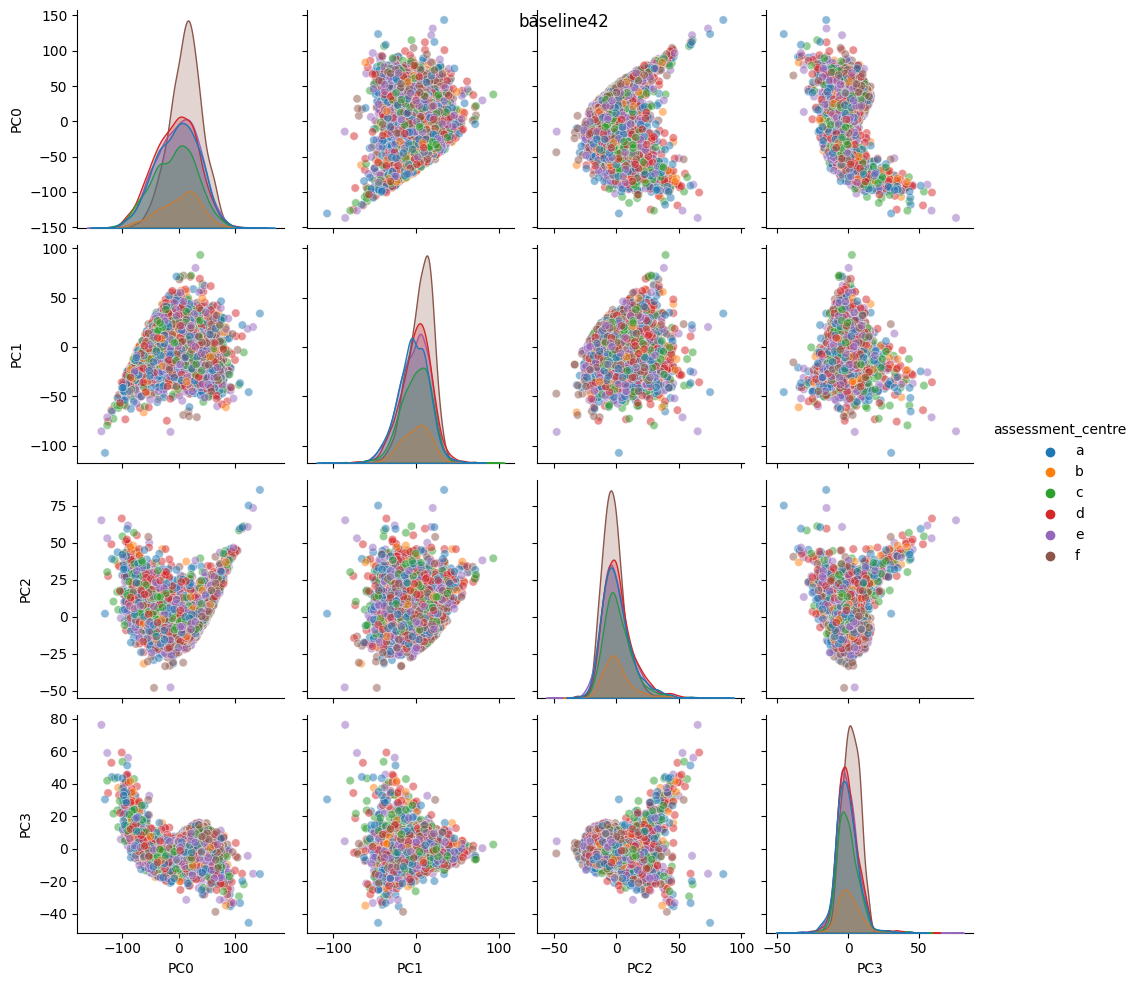

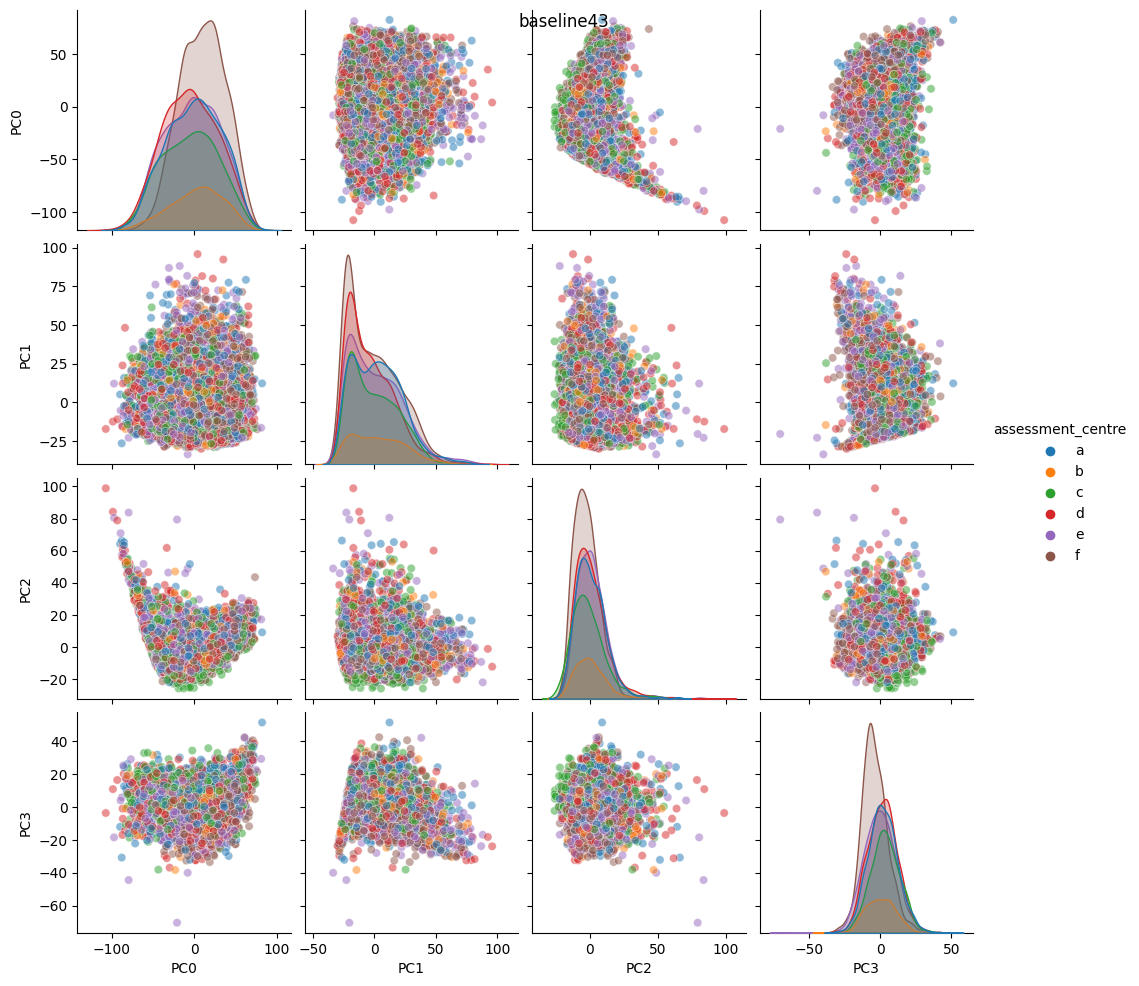

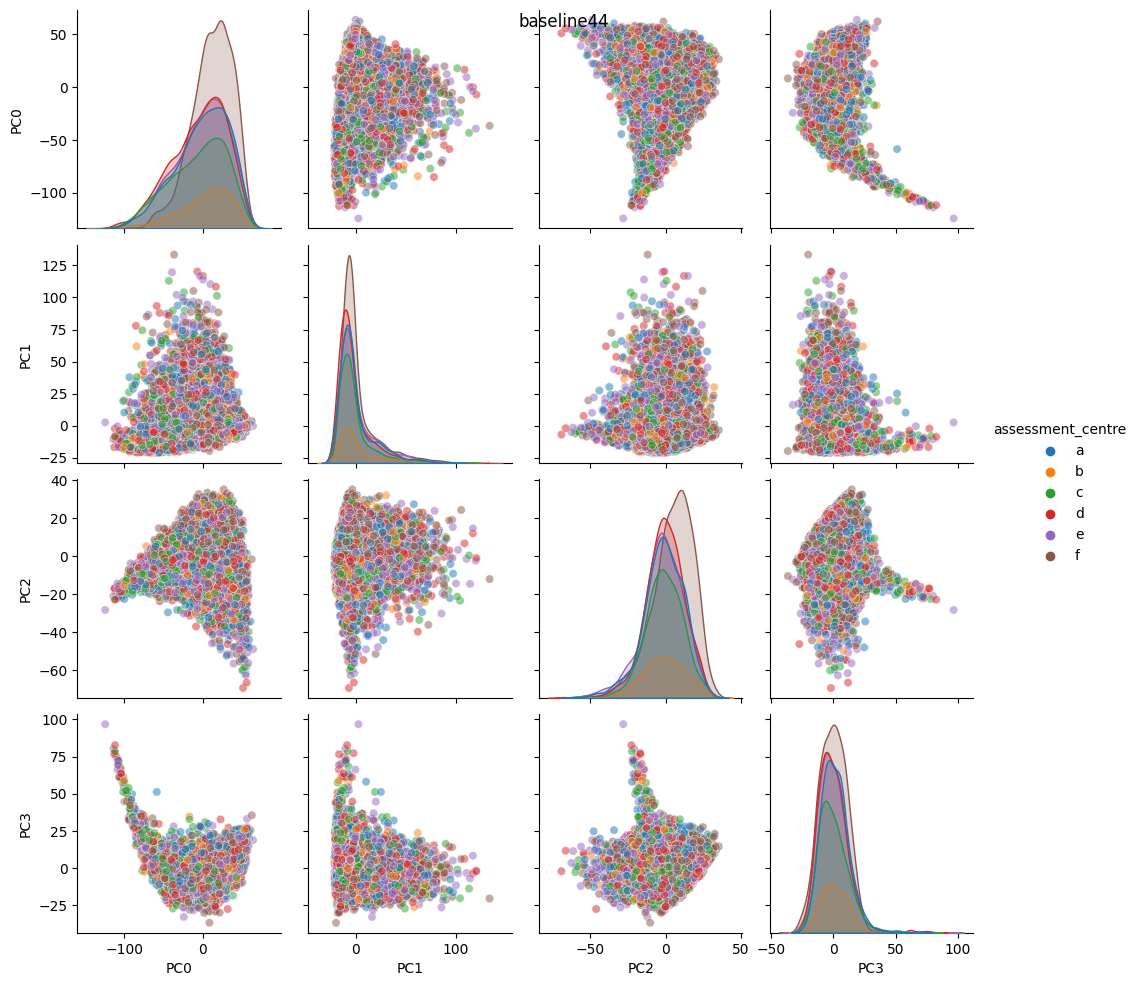

In [107]:
attribute = 'assessment_centre' # or 'Age_multi' 'label' ...
for experiment in bsl_experiment_dict.keys():
    results_df = bsl_experiment_dict[experiment]
    sns.pairplot(results_df, hue=attribute,vars=['PC0','PC1','PC2','PC3'],plot_kws={'alpha':0.5})
    plt.suptitle(bsl_folder + experiment)

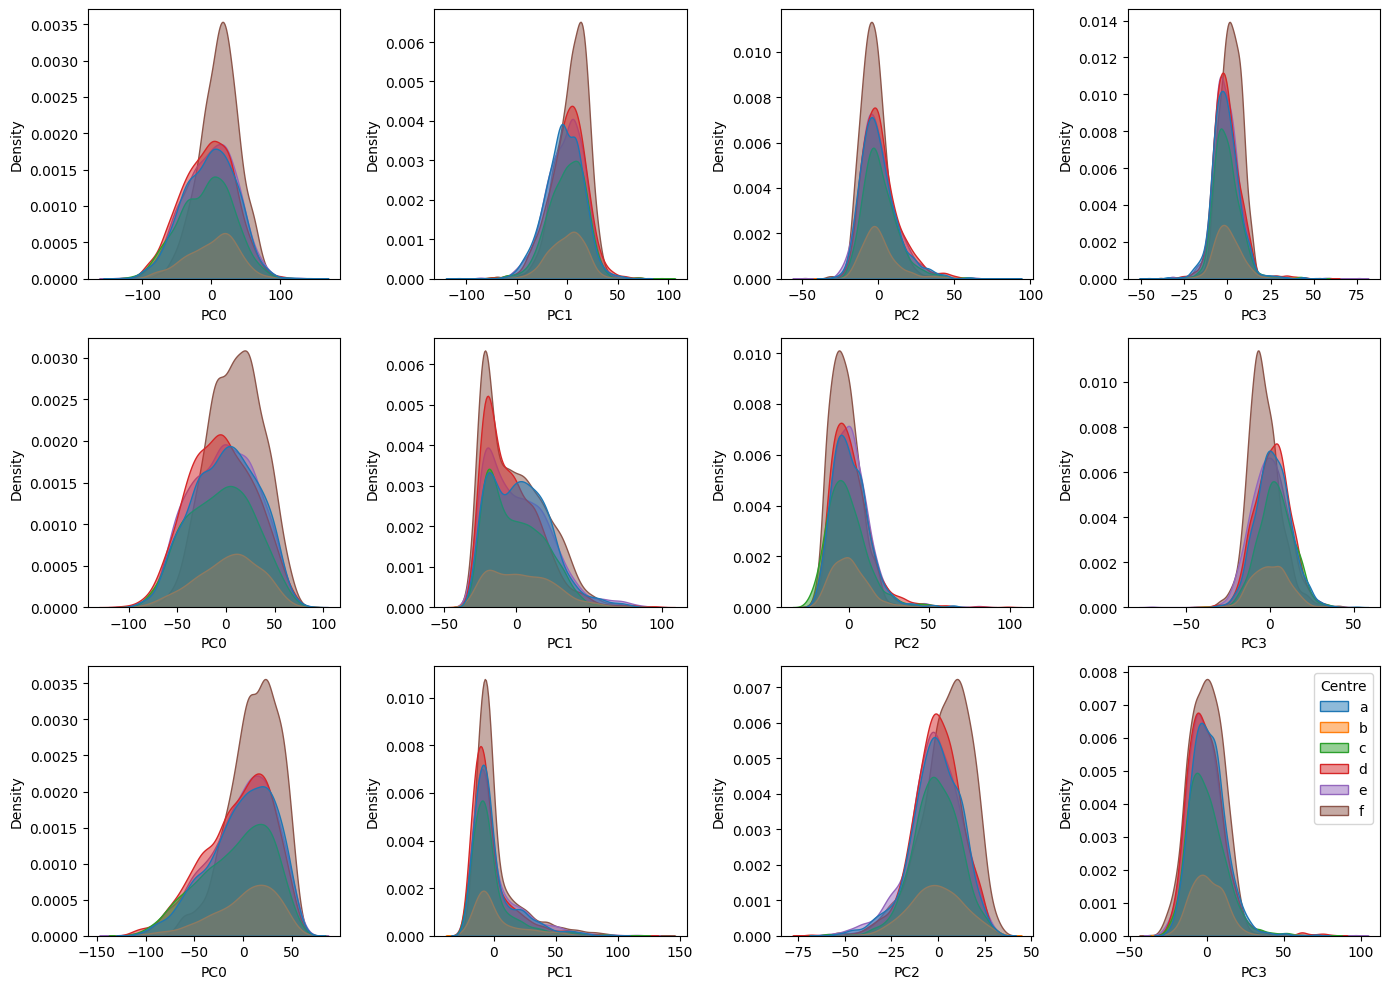

In [108]:
n_components = 4
fig, axs = plt.subplots(3, n_components, figsize=(14,10))
k = 0

for experiment in bsl_experiment_dict.keys():
    results_df = bsl_experiment_dict[experiment]
    for i in range(n_components):
        sns.kdeplot(data=results_df, x=f'PC{i}', hue='assessment_centre', alpha=0.5, fill=True, ax=axs[k,i])
        axs[k,i].legend_.set_title('Centre')
        #(fontsize='x-small')
        if (i != 3 or k != 2):
            axs[k,i].legend_.remove()
    k+=1

# Make the legend smaller
plt.tight_layout()
plt.show()

Compute distance between features

In [110]:
from scipy.stats import wasserstein_distance

In [111]:
data = []
assessment_centres = results_df['assessment_centre'].unique()

for experiment in bsl_experiment_dict.keys():
    print(experiment)
    results_df = bsl_experiment_dict[experiment]
    emd_dict = {centre: [] for centre in assessment_centres}
    for pc in ['PC0', 'PC1', 'PC2', 'PC3']:

        # Calculate pairwise EMDs
        for centre1 in assessment_centres:
            dist = wasserstein_distance(results_df.loc[results_df['assessment_centre'] == centre1, pc],
                                    results_df.loc[results_df['assessment_centre'] != centre1, pc])


            # Store the EMD in the dictionary for both centres
            emd_dict[centre1].append(dist)

        # Calculate the average EMD for each centre and store in the data list
        for centre, emds in emd_dict.items():
            average_emd = np.mean(emds)
            data.append([experiment, pc,centre, average_emd])
        
emd_df = pd.DataFrame(data, columns=['Experiment', 'PC', 'Centre', 'Average EMD'])
summary_df = pd.DataFrame(emd_df.groupby(['Centre','PC']).agg(['mean', 'std'])['Average EMD'].reset_index())

summary_df.sort_values(by=['PC'])

pivot_df = summary_df.pivot(index='Centre', columns='PC')
mean_df = pivot_df['mean'].round(3)
std_df = pivot_df['std'].round(3)

std_df = ' (' + std_df.astype(str) + ')'
mean_df = mean_df.astype(str)
mean_df = mean_df + std_df

mean_df

42
43
44


PC,PC0,PC1,PC2,PC3
Centre,,,,
a,2.06 (1.022),2.434 (1.389),2.037 (0.73),1.949 (0.533)
b,2.41 (0.382),2.423 (0.849),1.982 (0.572),1.669 (0.482)
c,7.774 (1.343),4.649 (0.917),3.682 (0.66),3.236 (0.261)
d,6.739 (0.274),4.579 (0.637),3.569 (0.358),2.973 (0.367)
e,3.072 (0.473),2.546 (0.06),2.309 (0.297),1.94 (0.211)
f,14.289 (1.496),8.941 (1.973),7.35 (1.278),6.289 (0.721)


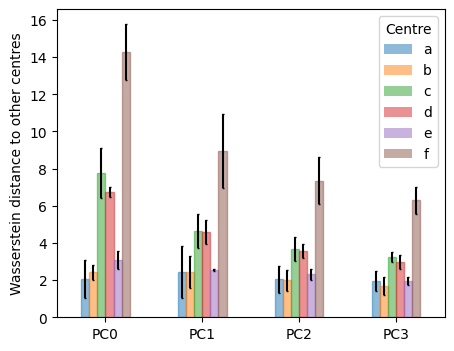

In [112]:
fig, ax = plt.subplots(figsize=(5, 4))  # Increase the figure width
pivot_df['mean'].T.plot(kind='bar', yerr=pivot_df['std'].T, capsize=1, alpha=0.5, ax=ax)
for bar in ax.patches:
    bar.set_edgecolor(bar.get_facecolor())

plt.xticks(rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Wasserstein distance to other centres")

plt.show()

## Adaptive model threshold selection (recalibration)

In [103]:
from mynotebooks.results_utils import *

In [104]:
subgroups = ['Age_multi','Age_binary','Sex','bmi_cat','assessment_centre','ethnicity','gen_ethnicity']

list_of_dfs = []
test_pred_list = []
adapted_test_preds = {}
for random_seed in ['42','43','44']:
    test_preds = all_models_dict[random_seed]['test_preds']

    # Initialize dictionary to store thresholds and predictions
    thresholds = {}
    predictions = {}
    
    random_seed_test_preds = {}

    # Process each subgroup
    for subgroup in subgroups:
        thresholds[subgroup] = {}

        grouped = test_preds.groupby(subgroup)

        for name, group in grouped:
            # Calculate threshold for the current subgroup
            group = group.reset_index(drop=True)
            threshold = find_threshold_anissa(group['raw_pred'], group['binary_label'])
            thresholds[subgroup][name] = threshold
        
        subgroup_df = test_preds.copy()
        subgroup_df['pred'] = subgroup_df.apply(lambda row: row['raw_pred']>thresholds[subgroup][row[subgroup]],axis=1).astype(int) #thresholds[subgroup][row[subgroup]].astype(int))
        random_seed_test_preds[subgroup] = subgroup_df
    
    random_seed_test_preds['baseline'] = all_models_dict[random_seed]['test_preds']
    adapted_test_preds[random_seed] = random_seed_test_preds
    # Calculate the metrics for each pred
    calc_subgroups = ['baseline','Age_multi','Age_binary','Sex','bmi_cat','assessment_centre','ethnicity','gen_ethnicity']
    metrics = pd.DataFrame({subgroup: calculate_metrics(random_seed_test_preds[subgroup], 'pred') for subgroup in calc_subgroups})
    metrics.T.round(3)

    list_of_dfs.append(metrics)


/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:51: RuntimeWarning: invalid value encountered in divide
  score = f1+np.multiply(0.25,tnrs)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:51: RuntimeWarning: invalid value encountered in divide
  score = f1+np.multiply(0.25,tnrs)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:51: RuntimeWarning: invalid value encountered in divide
  score = f1+np.multiply(0.25,tnrs)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/mynotebooks/results_utils.py:51: RuntimeWarning: invalid value encountered in divide
  score = f1+np.multiply(0.25,tnrs)


In [29]:
age_save_folder = '' # path to save results from recalibration 
sex_save_folder = ''
centre_save_folder = ''

for random_seed in ['42','43','44']:
    save_folder = age_save_folder + random_seed
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    adapted_test_preds[random_seed]['Age_multi'].to_csv(os.path.join(save_folder,'pretrained_pred.csv'))

for random_seed in ['42','43','44']:
    save_folder = sex_save_folder + random_seed
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    adapted_test_preds[random_seed]['Sex'].to_csv(os.path.join(save_folder,'pretrained_pred.csv'))

for random_seed in ['42','43','44']:
    save_folder = centre_save_folder + random_seed
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)

    adapted_test_preds[random_seed]['assessment_centre'].to_csv(os.path.join(save_folder,'pretrained_pred.csv'))

In [105]:
df = pd.DataFrame(thresholds)
df

,Age_multi,Age_binary,Sex,bmi_cat,assessment_centre,ethnicity,gen_ethnicity
0,0.584825,0.616910,NaN,0.717779,NaN,NaN,0.616910
1,0.611677,0.662932,NaN,0.661985,NaN,NaN,0.662932
2,0.700388,NaN,NaN,0.609813,NaN,NaN,NaN
3,0.670306,NaN,NaN,0.669662,NaN,NaN,NaN
F,NaN,NaN,0.662932,NaN,NaN,NaN,NaN
M,NaN,NaN,0.660871,NaN,NaN,NaN,NaN
11014.0,NaN,NaN,NaN,NaN,0.612469,NaN,NaN
11016.0,NaN,NaN,NaN,NaN,0.496071,NaN,NaN
11018.0,NaN,NaN,NaN,NaN,0.717298,NaN,NaN
11020.0,NaN,NaN,NaN,NaN,0.664899,NaN,NaN
